# Defensive Stock Analysis

Which performs better Linear regression or time series? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import time
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn import preprocessing
from sklearn import utils
import statsmodels.api as sm
from pylab import rcParams
%matplotlib inline

In [2]:
# with zipfile.ZipFile("Data/archive.zip") as zip_ref:
#     zip_ref.extractall("Data")

In [3]:
df1 = pd.read_csv('Data/sp500_companies.csv')
df2 = pd.read_csv('Data/sp500_index.csv')
df3 = pd.read_csv('Data/sp500_stocks.csv')
dfg = pd.read_csv('Data/daily_gold_rate.csv')
deth = pd.read_csv('Data/CBETHUSD.csv')
dollar = pd.read_csv('Data/DTWEXBGS.csv')
ppi = pd.read_csv('Data/WPU02850113.csv')

### Datasets 

### Dataset #1

In [4]:
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,149.70,2381442449408,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.067072
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,247.11,1855296897024,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.052254
2,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.41,1249782136832,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.73,1249780563968,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,100.79,1028229365760,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.028960


In [5]:
df1 = df1[df1['Sector'] == 'Consumer Defensive']
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
11,NYQ,WMT,Walmart Inc.,Walmart Inc.,Consumer Defensive,Discount Stores,142.58,395499831296,3.458600e+10,0.084,Bentonville,AR,United States,2300000.0,Walmart Inc. engages in the operation of retai...,0.011139
13,NYQ,PG,Procter & Gamble Company (The),The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,140.97,341140373504,2.136400e+10,0.013,Cincinnati,OH,United States,106000.0,The Procter & Gamble Company provides branded ...,0.009608
20,NYQ,KO,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,61.32,264866824192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,"The Coca-Cola Company, a beverage company, man...",0.007460
22,NMS,PEP,"Pepsico, Inc.","PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,178.05,246180839424,1.515600e+10,0.088,Purchase,NY,United States,309000.0,"PepsiCo, Inc. manufactures, markets, distribut...",0.006934
23,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,515.47,228575887360,9.693000e+09,0.150,Issaquah,WA,United States,304000.0,"Costco Wholesale Corporation, together with it...",0.006438


### Dataset #2

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   S&P500  2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [7]:
df2.head()

,Date,S&P500
0,2012-11-12,1380.03
1,2012-11-13,1374.53
2,2012-11-14,1355.49
3,2012-11-15,1353.33
4,2012-11-16,1359.88


In [8]:
df2.shape

(2519, 2)

In [9]:
df2['Date'] = pd.to_datetime(df2['Date'],infer_datetime_format=True)

In [10]:
df2=df2[df2['Date'] >= '2019-01-1']

In [11]:
df2 = df2.rename(columns={"S&P500":"S&PClose"})

In [12]:
df2['Symbol'] = "S&P500"

In [13]:
df2.head()

,Date,S&PClose,Symbol
1544,2019-01-02,2510.03,S&P500
1545,2019-01-03,2447.89,S&P500
1546,2019-01-04,2531.94,S&P500
1547,2019-01-07,2549.69,S&P500
1548,2019-01-08,2574.41,S&P500


In [14]:
df2.isna().sum()

Date        0
S&PClose    0
Symbol      0
dtype: int64

### Dataset #3

In [15]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629217 entries, 0 to 1629216
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1629217 non-null  object 
 1   Symbol     1629217 non-null  object 
 2   Adj Close  1560290 non-null  float64
 3   Close      1560290 non-null  float64
 4   High       1560290 non-null  float64
 5   Low        1560290 non-null  float64
 6   Open       1560290 non-null  float64
 7   Volume     1560290 non-null  float64
dtypes: float64(6), object(2)
memory usage: 99.4+ MB


In [16]:
df3['Date'] = pd.to_datetime(df3['Date'])

In [17]:
df3 = df3.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)

In [18]:
df3.head()

,Date,Symbol,Close
0,2010-01-04,MMM,83.019997
1,2010-01-05,MMM,82.500000
2,2010-01-06,MMM,83.669998
3,2010-01-07,MMM,83.730003
4,2010-01-08,MMM,84.320000


In [19]:
df3 = df3.loc[df3['Symbol'].isin(['PEP', 'KO', 'PG', 'WMT', 'COST'])]

In [20]:
df3.isna().sum()

Date      0
Symbol    0
Close     0
dtype: int64

In [21]:
df3['Date'] = pd.to_datetime(df3['Date'],infer_datetime_format=True)

In [22]:
df3=df3[df3['Date'] >= '2019-01-1']

In [23]:
df3.head()

,Date,Symbol,Close
384466,2019-01-02,KO,46.930000
384467,2019-01-03,KO,46.639999
384468,2019-01-04,KO,47.570000
384469,2019-01-07,KO,46.950001
384470,2019-01-08,KO,47.480000


### Dfg 

In [24]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9824 entries, 0 to 9823
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9824 non-null   object 
 1   USD     9824 non-null   float64
 2   EUR     9824 non-null   float64
 3   GBP     9824 non-null   float64
 4   INR     9824 non-null   float64
 5   AED     9824 non-null   float64
 6   CNY     9820 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.4+ KB


In [25]:
dfg = dfg.drop(['EUR','GBP','INR','AED','CNY'],axis=1)

In [26]:
dfg = dfg.rename(columns={"USD":"Gold"})

In [27]:
dfg.isna().sum()

Date    0
Gold    0
dtype: int64

In [28]:
dfg['Date'] = pd.to_datetime(dfg['Date'],infer_datetime_format=True)

In [29]:
dfg=dfg[dfg['Date'] >= '2019-01-1']

In [30]:
dfg.head()

,Date,Gold
8870,2019-01-01,1279.00
8871,2019-01-02,1282.90
8872,2019-01-03,1290.45
8873,2019-01-04,1279.90
8874,2019-01-07,1292.20


In [31]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 8870 to 9823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    954 non-null    datetime64[ns]
 1   Gold    954 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.4 KB


### Deth

In [32]:
deth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1827 non-null   object
 1   CBETHUSD  1827 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


In [33]:
deth.isna().sum()

DATE        0
CBETHUSD    0
dtype: int64

In [34]:
deth = deth.rename(columns={"DATE":"Date","CBETHUSD":"Ether"})

In [35]:
deth['Date'] = pd.to_datetime(deth['Date'],infer_datetime_format=True)

In [36]:
deth=deth[deth['Date'] >= '2019-01-1']

In [37]:
deth.head()

,Date,Ether
405,2019-01-01,139.75
406,2019-01-02,153.5
407,2019-01-03,147.23
408,2019-01-04,153.24
409,2019-01-05,154.21


### Dollar

In [38]:
dollar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DATE      1305 non-null   object
 1   DTWEXBGS  1305 non-null   object
dtypes: object(2)
memory usage: 20.5+ KB


In [39]:
dollar.isna().sum()

DATE        0
DTWEXBGS    0
dtype: int64

In [40]:
dollar = dollar.rename(columns={"DATE":"Date", "DTWEXBGS":"USD"})

In [41]:
dollar['Date'] = pd.to_datetime(dollar['Date'],infer_datetime_format=True)

In [42]:
dollar=dollar[dollar['Date'] >= '2019-01-1']

In [43]:
dollar.head()

,Date,USD
291,2019-01-01,.
292,2019-01-02,115.7681
293,2019-01-03,115.4621
294,2019-01-04,114.9822
295,2019-01-07,114.5631


In [44]:
dollar.tail()

,Date,USD
1300,2022-11-14,123.5788
1301,2022-11-15,123.1759
1302,2022-11-16,123.4178
1303,2022-11-17,124.1229
1304,2022-11-18,123.9828


### PPI 

In [45]:
ppi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         479 non-null    object 
 1   WPU02850113  479 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [46]:
ppi.isna().sum()

DATE           0
WPU02850113    0
dtype: int64

In [47]:
ppi = ppi.rename(columns={"DATE":"Date", "WPU02850113":"PPI"})

In [48]:
ppi['Date'] = pd.to_datetime(ppi['Date'],infer_datetime_format=True)

In [49]:
ppi=ppi[ppi['Date'] >= '2019-01-1']

In [50]:
ppi.head()

,Date,PPI
433,2019-01-01,188.3
434,2019-02-01,185.2
435,2019-03-01,186.4
436,2019-04-01,187.0
437,2019-05-01,184.6


### Merge datasets

In [51]:
df4 = pd.merge(df2,df3, on='Date', how='outer')

In [52]:
df4 = pd.merge(df4, dfg, on='Date')

In [53]:
df4 = pd.merge(df4, deth, on='Date')

In [54]:
df4 = pd.merge(df4, dollar, on='Date')

In [55]:
df4 = pd.merge(df4, ppi, on='Date')

In [56]:
df4.drop('Symbol_x', axis=1)

,Date,S&PClose,Symbol_y,Close,Gold,Ether,USD,PPI
0,2019-02-01,2706.53,KO,48.700001,1318.7,105.88,113.7529,185.200
1,2019-02-01,2706.53,COST,210.270004,1318.7,105.88,113.7529,185.200
2,2019-02-01,2706.53,PEP,112.190002,1318.7,105.88,113.7529,185.200
3,2019-02-01,2706.53,PG,97.470001,1318.7,105.88,113.7529,185.200
4,2019-02-01,2706.53,WMT,93.860001,1318.7,105.88,113.7529,185.200
...,...,...,...,...,...,...,...,...
145,2022-08-01,4118.63,KO,64.519997,1772.4,1629.76,121.5001,269.651
146,2022-08-01,4118.63,COST,546.809998,1772.4,1629.76,121.5001,269.651
147,2022-08-01,4118.63,PEP,176.949997,1772.4,1629.76,121.5001,269.651
148,2022-08-01,4118.63,PG,142.899994,1772.4,1629.76,121.5001,269.651


In [57]:
df4 = df4.rename(columns={'Symbol_y': 'Symbol'})

In [58]:
df4 = df4[['Date', 'Symbol', 'Close', 'S&PClose','Gold','Ether','USD','PPI']]

In [59]:
df4.head()

,Date,Symbol,Close,S&PClose,Gold,Ether,USD,PPI
0,2019-02-01,KO,48.700001,2706.53,1318.7,105.88,113.7529,185.2
1,2019-02-01,COST,210.270004,2706.53,1318.7,105.88,113.7529,185.2
2,2019-02-01,PEP,112.190002,2706.53,1318.7,105.88,113.7529,185.2
3,2019-02-01,PG,97.470001,2706.53,1318.7,105.88,113.7529,185.2
4,2019-02-01,WMT,93.860001,2706.53,1318.7,105.88,113.7529,185.2


In [60]:
df4['USD']=df4['USD'].astype(float)

In [61]:
df4['Ether']=df4['Ether'].astype(float)

In [62]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      150 non-null    datetime64[ns]
 1   Symbol    150 non-null    object        
 2   Close     150 non-null    float64       
 3   S&PClose  150 non-null    float64       
 4   Gold      150 non-null    float64       
 5   Ether     150 non-null    float64       
 6   USD       150 non-null    float64       
 7   PPI       150 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 10.5+ KB


### EDA

In [63]:
symbol_groups = df4.groupby(by='Symbol')

In [64]:
# corr = symbol_groups.corr()
# corr

# why is Ether USD and PPI not showing up?

In [65]:
# # Build heatmap

# # Set up figure and axis
# fig, ax = plt.subplots(figsize=(25, 20))

# sns.heatmap(symbol_groups.corr(), 
#             # Mask to show only half the values instead of showing duplicates
#             mask=np.triu(np.ones_like(corr, dtype=bool)),
#             # Specifies that we want values not just colors
#             annot = True,
#             linewidths = 10,
#             center=0);

# ax.hlines([6, 12, 18, 24],*ax.get_xlim())

In [66]:
COST = symbol_groups.get_group('COST')
WMT = symbol_groups.get_group('WMT')
KO = symbol_groups.get_group('KO')
PG = symbol_groups.get_group('PG')
PEP = symbol_groups.get_group('PEP')

### COST EDA 

In [67]:
cost_corr = COST.corr()
cost_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.889469,0.747417,0.816349,0.026124,0.799072
S&PClose,0.889469,1.000000,0.726014,0.918236,-0.363941,0.607492
Gold,0.747417,0.726014,1.000000,0.564521,-0.008767,0.509451
Ether,0.816349,0.918236,0.564521,1.000000,-0.338625,0.454566
USD,0.026124,-0.363941,-0.008767,-0.338625,1.000000,0.219452
PPI,0.799072,0.607492,0.509451,0.454566,0.219452,1.000000


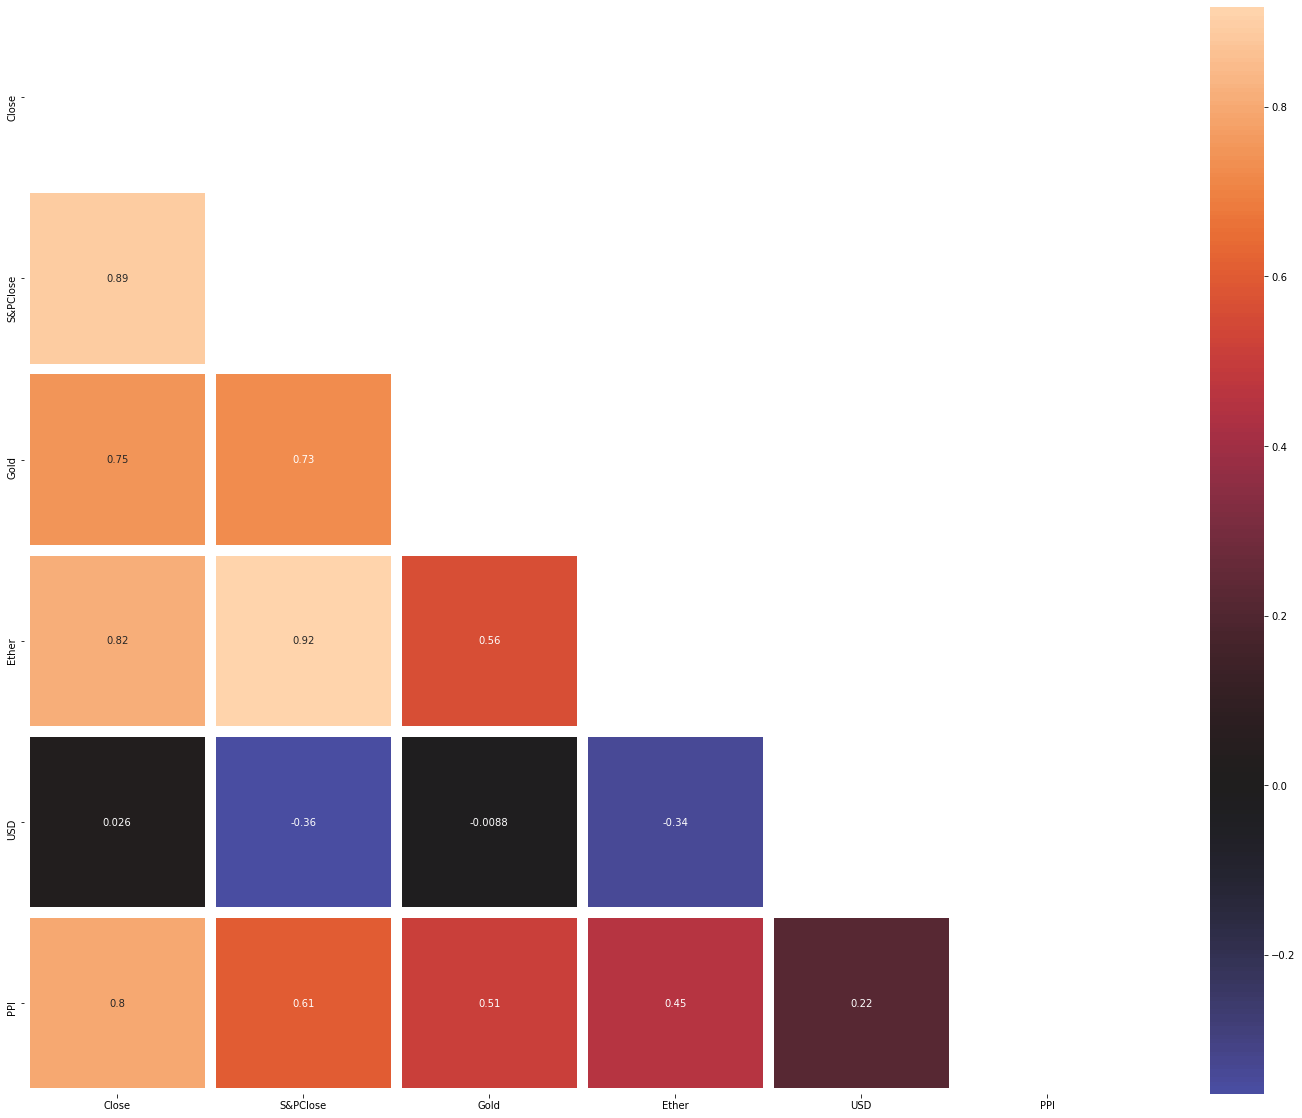

In [68]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(COST.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(cost_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

# ax.hlines([6, 12, 18, 24],*ax.get_xlim())

<AxesSubplot:xlabel='Date'>

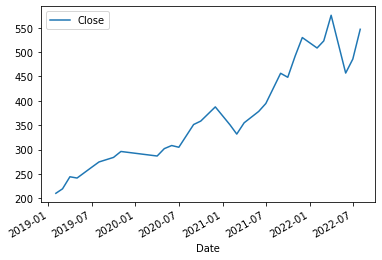

In [69]:
COST.plot(x='Date',y='Close')

### WMT EDA

In [70]:
wmt_corr = WMT.corr()
wmt_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.794307,0.901195,0.662717,-0.247395,0.371778
S&PClose,0.794307,1.000000,0.726014,0.918236,-0.363941,0.607492
Gold,0.901195,0.726014,1.000000,0.564521,-0.008767,0.509451
Ether,0.662717,0.918236,0.564521,1.000000,-0.338625,0.454566
USD,-0.247395,-0.363941,-0.008767,-0.338625,1.000000,0.219452
PPI,0.371778,0.607492,0.509451,0.454566,0.219452,1.000000


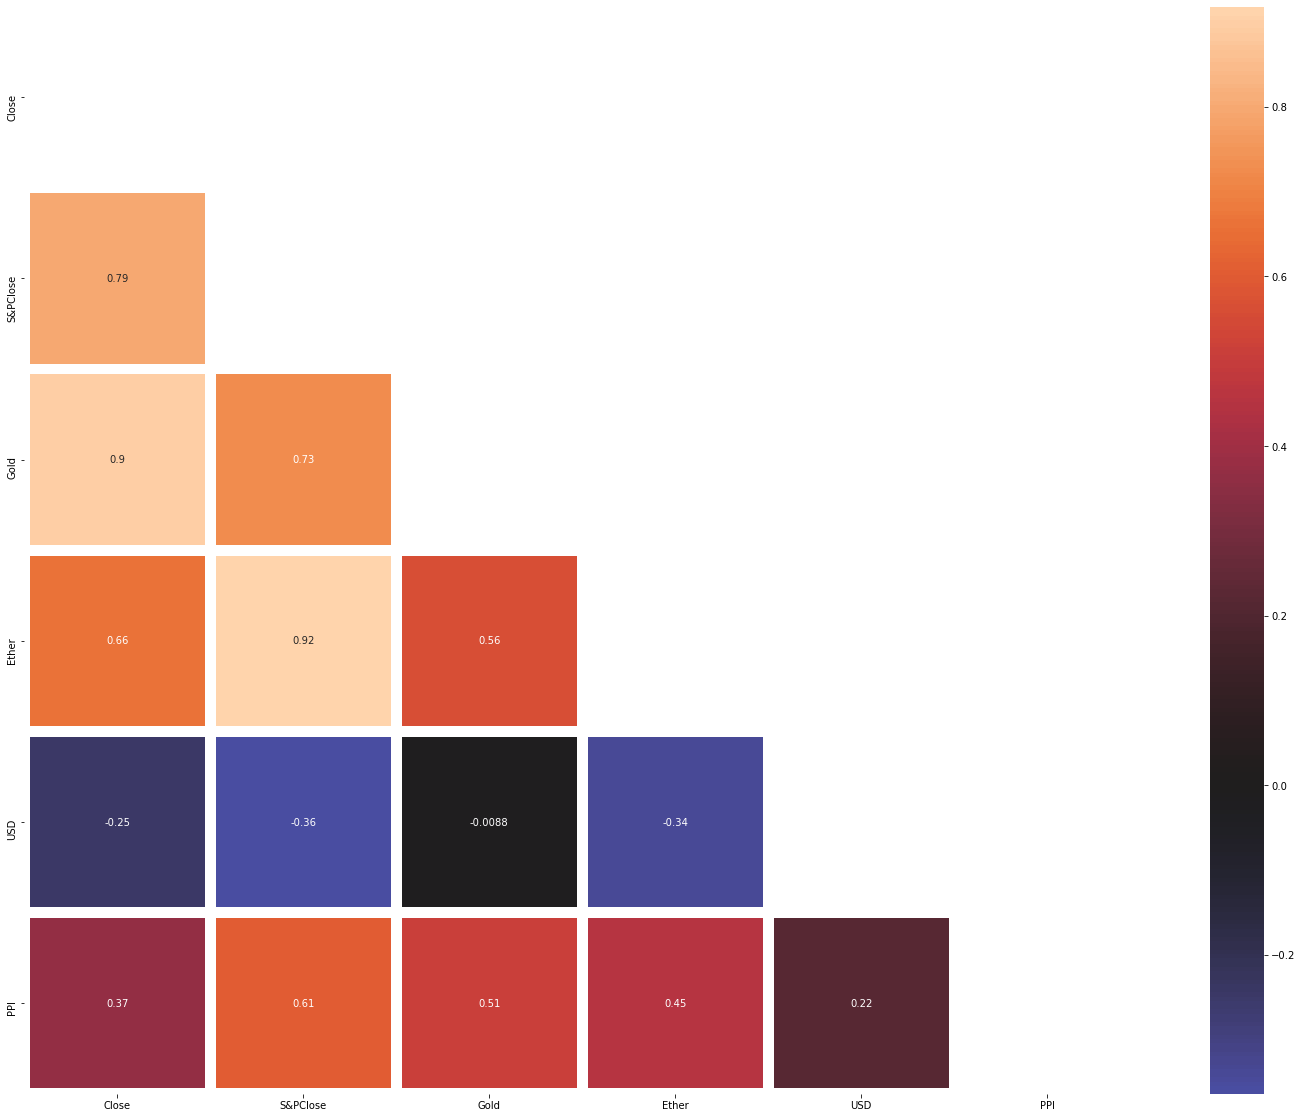

In [71]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(WMT.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(wmt_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

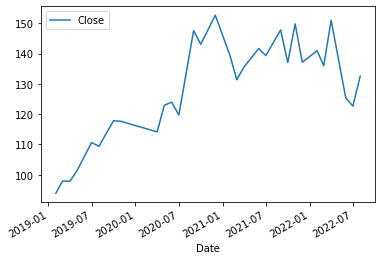

In [72]:
WMT.plot(x='Date',y='Close')

### KO EDA 

In [73]:
ko_corr = KO.corr()
ko_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.700515,0.437022,0.552605,-0.027155,0.858936
S&PClose,0.700515,1.000000,0.726014,0.918236,-0.363941,0.607492
Gold,0.437022,0.726014,1.000000,0.564521,-0.008767,0.509451
Ether,0.552605,0.918236,0.564521,1.000000,-0.338625,0.454566
USD,-0.027155,-0.363941,-0.008767,-0.338625,1.000000,0.219452
PPI,0.858936,0.607492,0.509451,0.454566,0.219452,1.000000


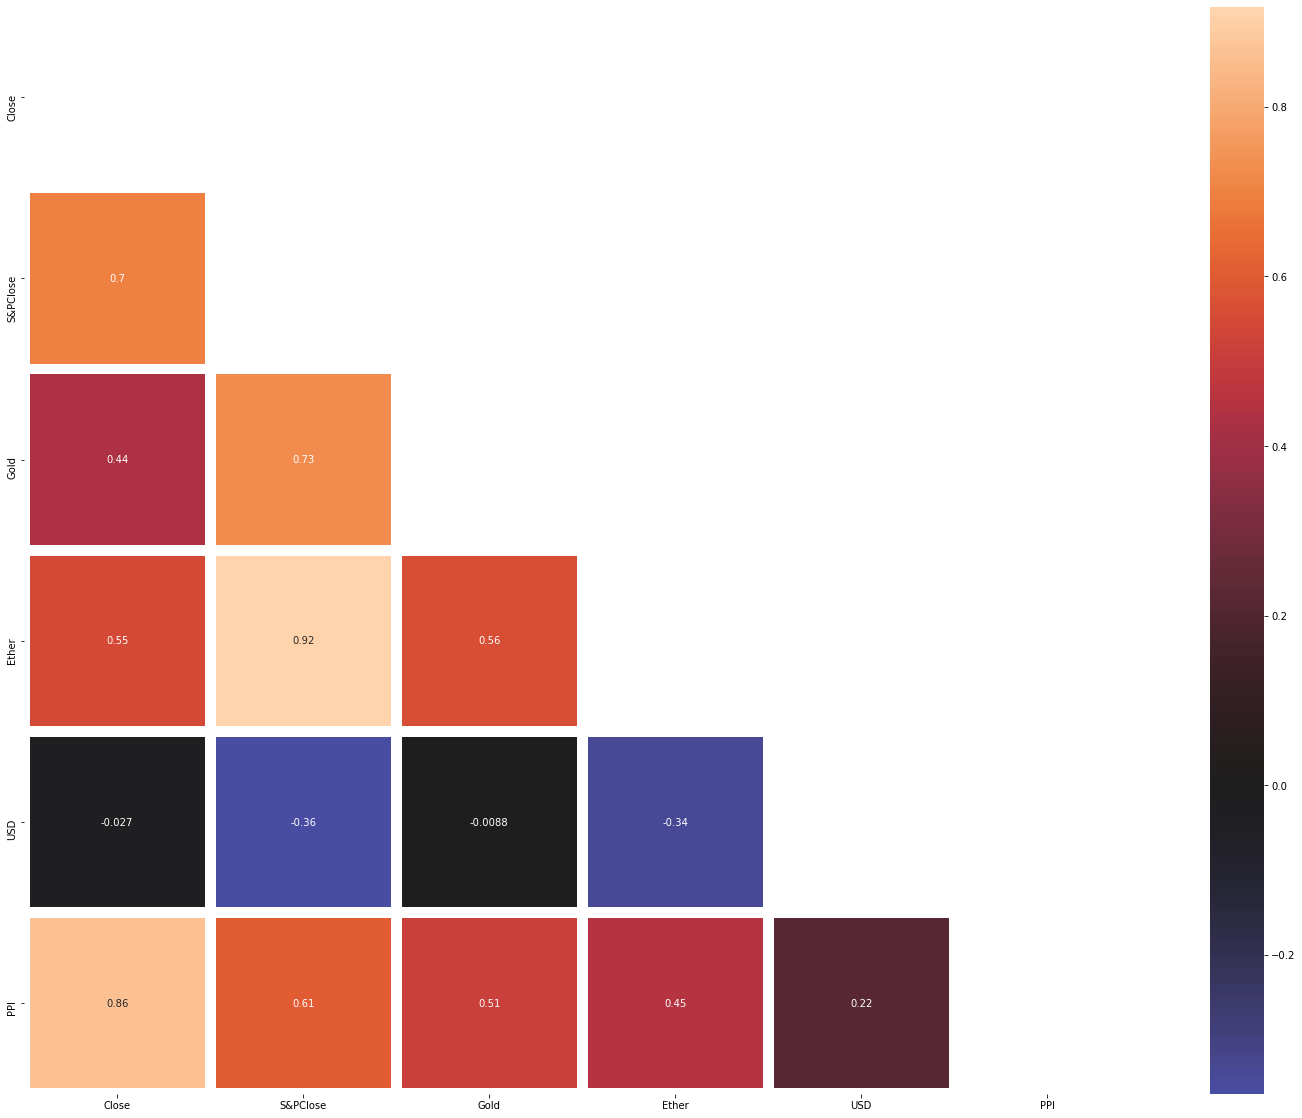

In [74]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(KO.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(ko_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

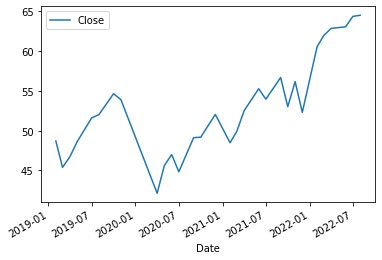

In [75]:
KO.plot(x='Date',y='Close')

### PG EDA 

In [76]:
pg_corr = PG.corr()
pg_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.877302,0.839692,0.730754,-0.068138,0.745125
S&PClose,0.877302,1.000000,0.726014,0.918236,-0.363941,0.607492
Gold,0.839692,0.726014,1.000000,0.564521,-0.008767,0.509451
Ether,0.730754,0.918236,0.564521,1.000000,-0.338625,0.454566
USD,-0.068138,-0.363941,-0.008767,-0.338625,1.000000,0.219452
PPI,0.745125,0.607492,0.509451,0.454566,0.219452,1.000000


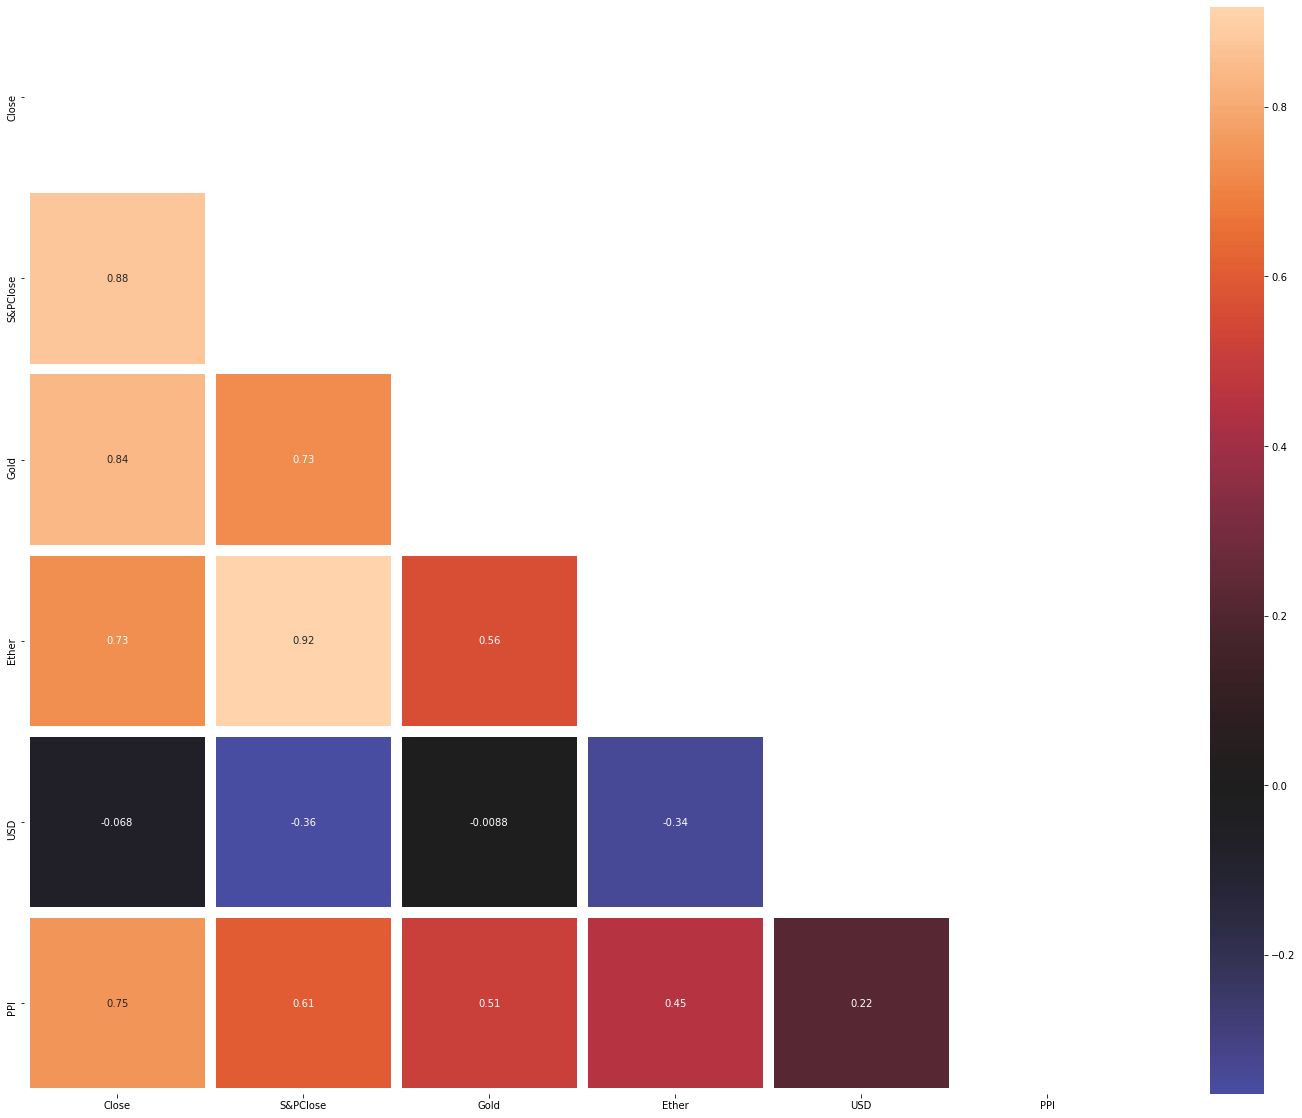

In [77]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(PG.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(pg_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

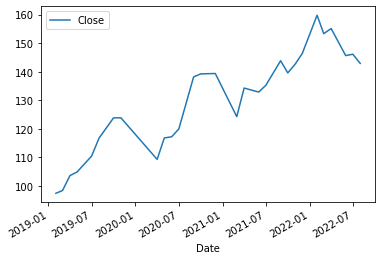

In [78]:
PG.plot(x='Date',y='Close')

### PEP EDA 

In [79]:
pep_corr = PEP.corr()
pep_corr

,Close,S&PClose,Gold,Ether,USD,PPI
Close,1.000000,0.853652,0.689322,0.721479,0.041085,0.840919
S&PClose,0.853652,1.000000,0.726014,0.918236,-0.363941,0.607492
Gold,0.689322,0.726014,1.000000,0.564521,-0.008767,0.509451
Ether,0.721479,0.918236,0.564521,1.000000,-0.338625,0.454566
USD,0.041085,-0.363941,-0.008767,-0.338625,1.000000,0.219452
PPI,0.840919,0.607492,0.509451,0.454566,0.219452,1.000000


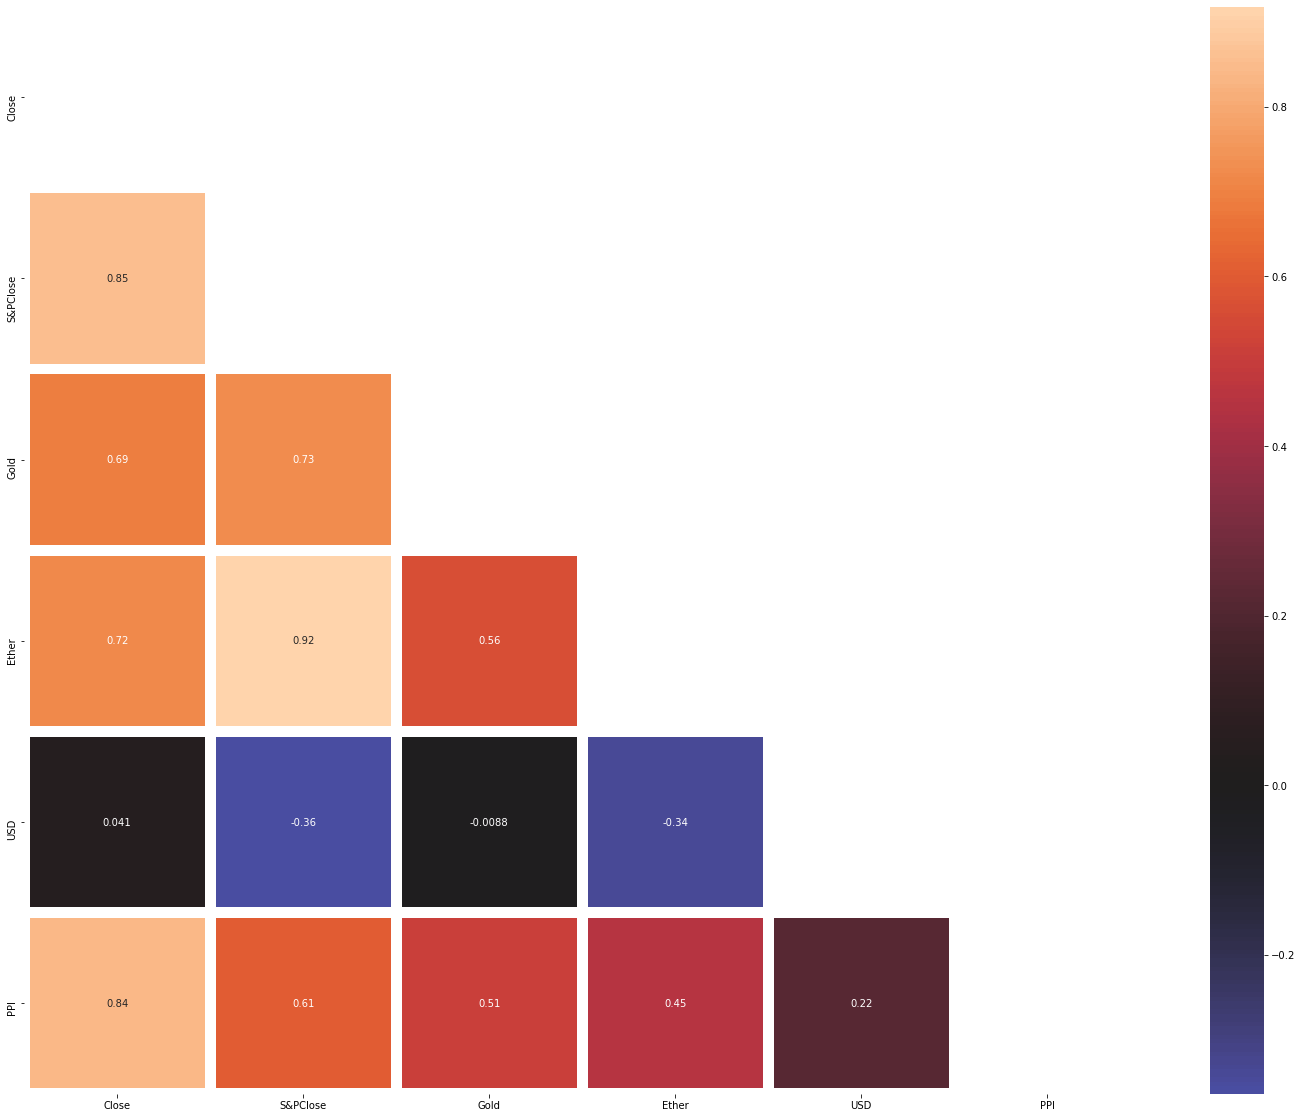

In [80]:
# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(PEP.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(pep_corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            linewidths = 10,
            center=0);

<AxesSubplot:xlabel='Date'>

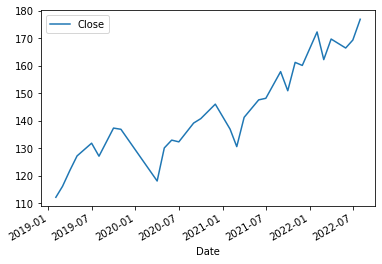

In [81]:
PEP.plot(x='Date',y='Close')

### Preprocessing

In [82]:
# cols = ['S&PClose','Gold','PPI','Ether','USD','Symbol']
# col_order = ['Date','Close']
# COST.drop(cols, axis=1, inplace=True)

In [83]:
COST = COST.drop(['S&PClose','Gold','PPI','Ether','USD','Symbol'],axis=1)
COST.head()

,Date,Close
1,2019-02-01,210.270004
6,2019-03-01,219.440002
11,2019-04-01,244.190002
16,2019-05-01,241.589996
21,2019-07-01,263.549988


In [84]:
COST.head(40)

,Date,Close
1,2019-02-01,210.270004
6,2019-03-01,219.440002
11,2019-04-01,244.190002
16,2019-05-01,241.589996
21,2019-07-01,263.549988
26,2019-08-01,274.570007
31,2019-10-01,283.929993
36,2019-11-01,296.089996
41,2020-04-01,286.779999
46,2020-05-01,301.920013


In [85]:
# stock_c = stock_c.reindex(columns=col_order)

In [86]:
# monthly_mean = stock_c['Close'].resample('D').mean()

In [87]:
# COST = COST.drop(['S&PClose','Gold','PPI','Ether','USD','Symbol'],axis=1)
# COST.head()

In [88]:
# error = np.random.normal(0, 2, len(COST['Date']))
# Y_0 = 8
# mu = 5
# phi = 0.7

In [89]:
# TS = [None] * len(COST['Date'])
# y = Y_0
# for i, row in enumerate(COST['Date']):
#     TS[i] = mu + y * phi + error[i]
#     y = TS[i] - mu

In [90]:
# series = pd.Series(TS, index=COST['Date'])
# series.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [91]:
# series.shape

In [92]:
# fig, ax = plt.subplots(figsize=(16,3))
# plot_acf(series, ax=ax, lags=14);

# fig, ax = plt.subplots(figsize=(16,3))
# plot_pacf(series, ax=ax, lags=14);

In [93]:
# mod_arma = ARIMA(series, order=(1,0,0))

In [94]:
# res_arma = mod_arma.fit()

In [95]:
# print(res_arma.summary())

### Logistic Regression